# Character Tracking
As part of our overall effort to follow the events of the film, we'll want to track characters throughout the movie. We do this by creating dictionaries which will primarily recognize characters by face - more specifically, their facial encoding clusters.

In [1]:
import sys
sys.path.append('../data_serialization')
from serialization_preprocessing_io import *
from time_reference_io import *
from scene_identification_io import *
from collections import Counter
from character_identification_io import *
import matplotlib.pyplot as plt

In [2]:
film = 'plus_one_2019'
srt_df, subtitle_df, sentence_df, vision_df, face_df = read_pickle(film)
scene_dictionaries = generate_scenes(vision_df, face_df, substantial_minimum=4, anchor_search=8)

We begin by creating a dictionary of scenes. Recall that each scene was found because there was a character in the left anchor shots, and another character in the right anchor shots. Because of the inconsistencies in face clustering, there may be multiple face clusters associated with a character.

So in a single scene, we're pretty confident that every face in a left anchor shot is the same character, and every face in a right anchor shot is the same character.

In [3]:
scene_dictionaries[1]

{'scene_id': 1,
 'first_frame': 483,
 'last_frame': 527,
 'scene_duration': 45,
 'left_anchor_shot_cluster': 179,
 'left_anchor_face_cluster': 3.0,
 'matching_left_face_clusters': [11.0],
 'right_anchor_shot_cluster': 86,
 'right_anchor_face_cluster': 15.0,
 'matching_right_face_clusters': [5.0],
 'cutaway_shot_clusters': [39]}

So for the first scene, we know that the left anchor character can be represented by two separate face clusters: 3 and 11. The right anchor character can be represented by two face clusters: 15 and 5. We'll attempt to use this logic and join these clusters together in all the film's scenes.
### Figuring out each characters' different face encodings
We'll iterate through each scene and do the same thing: look at the faces on the left, and look at the faces on the right. We'll assume that all the left faces are a character, and all the right faces are another character.

In [4]:
anchor_face_cluster_lists = []

x = 1

while x <= len(scene_dictionaries):
    scene_left_list = []

    scene_left_list.append(scene_dictionaries[x]['left_anchor_face_cluster'])

    for matching_left_face in scene_dictionaries[x]['matching_left_face_clusters']:
        scene_left_list.append(matching_left_face)

    scene_right_list = []

    scene_right_list.append(scene_dictionaries[x]['right_anchor_face_cluster'])

    for matching_right_face in scene_dictionaries[x]['matching_right_face_clusters']:
        scene_right_list.append(matching_right_face)

    anchor_face_cluster_lists.append(scene_left_list)
    anchor_face_cluster_lists.append(scene_right_list)

    x += 1

So for each of the 18 scenes, we create two lists (one for the left, and one for the right). We end up with 36 lists, each linking some face clusters together.

In [5]:
print(len(scene_dictionaries))
print(len(anchor_face_cluster_lists))

18
36


In [6]:
anchor_face_cluster_lists

[[3.0, 11.0],
 [15.0, 5.0],
 [8.0, 2.0],
 [11.0, 17.0],
 [2.0, 8.0],
 [3.0, 13.0, 0.0, 11.0],
 [2.0, 8.0],
 [11.0, 3.0],
 [2.0, 8.0],
 [3.0, 11.0],
 [3.0],
 [1.0],
 [28.0],
 [10.0, 7.0, 8.0],
 [4.0],
 [3.0, 17.0],
 [3.0],
 [26.0],
 [2.0],
 [17.0, 11.0],
 [2.0, 8.0],
 [11.0, 17.0, 3.0],
 [22.0, 8.0],
 [8.0],
 [22.0, 2.0],
 [17.0, 3.0, 11.0],
 [22.0],
 [17.0],
 [17.0, 0.0, 13.0, 31.0],
 [14.0],
 [31.0],
 [2.0, 8.0],
 [31.0, 11.0, 3.0],
 [2.0, 8.0],
 [10.0, 2.0],
 [11.0]]

In [7]:
print(anchor_face_cluster_lists[0])
print(anchor_face_cluster_lists[7])

[3.0, 11.0]
[11.0, 3.0]


We'll want to count the clusters that show up most often, and we'll use these as the basis of matching face encodings.

In [8]:
flattened_anchor_list = []
for anchor_list in anchor_face_cluster_lists:
    for anchor in anchor_list:
        flattened_anchor_list.append(anchor)

anchor_character_counter = Counter(flattened_anchor_list)
most_common_anchors = []

common_count = 5
for anchor in anchor_character_counter.most_common(common_count):
    most_common_anchors.append(anchor[0])

In [9]:
most_common_anchors

[3.0, 11.0, 8.0, 2.0, 17.0]

For these five anchor faces, we'll see which other faces match them by looping through each scene they're in.

In [10]:
character_cluster_list = []

for character in most_common_anchors:
    matching_clusters = [character]
    search_clusters = []
    search_continues = 1

    # search face clusters of all scenes to find matching clusters, then repeat search until no more found
    while search_continues == 1:
        if search_clusters:
            matching_clusters = search_clusters.copy()
        for anchor_face_clusters in anchor_face_cluster_lists:
            for matching_cluster in matching_clusters:
                if matching_cluster in anchor_face_clusters:
                    for anchor_face in anchor_face_clusters:
                        search_clusters.append(anchor_face)
        search_clusters = list(set(search_clusters))

        if sorted(matching_clusters) == sorted(search_clusters):
            search_continues = 0
            character_cluster_list.append(sorted(matching_clusters))

character_cluster_list

[[0.0, 3.0, 11.0, 13.0, 17.0, 31.0],
 [0.0, 3.0, 11.0, 13.0, 17.0, 31.0],
 [2.0, 7.0, 8.0, 10.0, 22.0],
 [2.0, 7.0, 8.0, 10.0, 22.0],
 [0.0, 3.0, 11.0, 13.0, 17.0, 31.0]]

In [11]:
unique_character_clusters = []
for character_clusters in character_cluster_list:
    if character_clusters not in unique_character_clusters:
        unique_character_clusters.append(character_clusters)

unique_character_clusters

[[0.0, 3.0, 11.0, 13.0, 17.0, 31.0], [2.0, 7.0, 8.0, 10.0, 22.0]]

And we've just discovered all the face encodings matching the film's two main characters. This functionality is found in a function `generate_character_clusters()` in `character_identification_io`.

### Character Dictionaries
With the ability to group face encodings together into characters, we can search all scenes for these face encodings. For each of the two characters, we assign a character_id, list the clusters, and in which scenes they're found.

In [12]:
character_clusters = generate_character_clusters(scene_dictionaries)
character_dictionary_list = []

y = 1
for single_character_face_clusters in character_clusters:

    character_scenes = []

    x = 1
    while x <= len(scene_dictionaries):
        for cluster in single_character_face_clusters:
            if cluster == scene_dictionaries[x]['left_anchor_face_cluster'] or cluster in scene_dictionaries[x][
                'matching_left_face_clusters'] or cluster == scene_dictionaries[x][
                'right_anchor_face_cluster'] or cluster in scene_dictionaries[x]['matching_right_face_clusters']:
                character_scenes.append(x)
        x += 1

    character_scenes = sorted(list(set(character_scenes)))

    character_dict = {'character_id': y,
                      'face_clusters': single_character_face_clusters,
                      'scenes_present': character_scenes}

    character_dictionary_list.append(character_dict)
    y += 1

character_dictionary_list

[{'character_id': 1,
  'face_clusters': [0.0, 3.0, 11.0, 13.0, 17.0, 31.0],
  'scenes_present': [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18]},
 {'character_id': 2,
  'face_clusters': [2.0, 7.0, 8.0, 10.0, 22.0],
  'scenes_present': [2, 3, 4, 5, 7, 10, 11, 12, 13, 14, 16, 17, 18]}]

After this, we flatten the list into an actual dictionary.

In [13]:
character_dictionaries = {}
z = 1

for character_dict in character_dictionary_list:
    character_dictionaries[z] = character_dict
    z += 1

character_dictionaries

{1: {'character_id': 1,
  'face_clusters': [0.0, 3.0, 11.0, 13.0, 17.0, 31.0],
  'scenes_present': [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18]},
 2: {'character_id': 2,
  'face_clusters': [2.0, 7.0, 8.0, 10.0, 22.0],
  'scenes_present': [2, 3, 4, 5, 7, 10, 11, 12, 13, 14, 16, 17, 18]}}

This logic is wrapped in the function `generate_characters()`.

### Emotion Tracking
Because we know the faces of characters, we can track their emotions throughout the film. We'll plot the emotions of Ben, the first character in our dictionary because he's present in nearly every identified scene.

In [14]:
character_face_clusters = character_dictionaries[1]['face_clusters']
character_face_clusters

[0.0, 3.0, 11.0, 13.0, 17.0, 31.0]

We'll divide the film into eight portions called sequences. In modern screenwriting, films usually follow the eight-sequence structure, a more-defined variant of the typical three-act structure.

For now, we'll just divide the film evenly into eight portions. First, we'll define a new dataframe without the credits.

In [15]:
frame_before_credits = face_df[face_df['faces_found'] > 0].tail(1).index[0]  # final frame before credits
face_nocreds_df = face_df[0:frame_before_credits].copy()

Then, we'll partition the eight sequences by defining a new `sequence` column.

In [16]:
face_nocreds_df['sequence'] = pd.qcut(face_nocreds_df.index, q=8, labels=['1', '2', '3', '4', '5', '6', '7', '8'])
face_nocreds_df['sequence'] = face_nocreds_df['sequence'].astype(int)

An interesting plot would be the "upset percentage". In each sequence, what percentage of Ben's faces are upset? When he looks "sad" or "angry", we'll say he's upset.

In [17]:
sequences = range(1, 9)
sad_angry_percentage = []
for seq in sequences:
    try:
        sad_percentage = face_nocreds_df[
            (face_nocreds_df['p_face_cluster'].isin(character_face_clusters)) & (
                        face_nocreds_df['sequence'] == seq)].p_emotion.value_counts(normalize=True)['sad']
    except KeyError:
        sad_percentage = 0
    try:
        angry_percentage = face_nocreds_df[
            (face_nocreds_df['p_face_cluster'].isin(character_face_clusters)) & (
                        face_nocreds_df['sequence'] == seq)].p_emotion.value_counts(normalize=True)['angry']
    except KeyError:
        angry_percentage = 0
    sad_angry_percentage.append(100 * (sad_percentage + angry_percentage))

sad_angry_percentage

[34.50704225352113,
 40.0,
 46.55172413793103,
 57.446808510638306,
 41.880341880341874,
 47.82608695652174,
 63.18681318681318,
 39.62264150943396]

We can plot the upset percentage throughout the film. This roughly tracks with the traditional eight-sequence/three-act structure. Lots of emotion right before the mid-way point, and at the climax in sequence 7, before a happy ending.

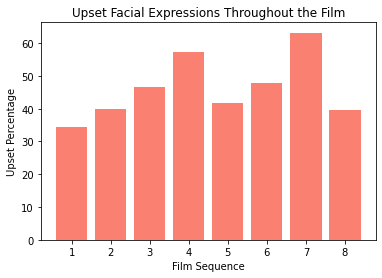

In [18]:
plt.bar(x=sequences, height=(sad_angry_percentage), color='salmon')
plt.xlabel('Film Sequence')
plt.ylabel('Upset Percentage')
plt.title('Upset Facial Expressions Throughout the Film')
plt.show()

This is available as a function `plot_character_filmwide_emotion()`.